In [1]:
import random
import itertools as it
import time

import pandas as pd
import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

datasets = [dataset_A, dataset_B]

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset):
    cost = dataset["cost"].sum()
    for i in range(-1, len(dataset) - 1):
        cost += euclidean_distance(dataset.iloc[i], dataset.iloc[i + 1])
    return int(cost)

In [8]:
def calculate_distance_matrix(dataset):
    n_nodes = len(dataset)
    distance_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float64)
    for i, j in it.product(range(n_nodes), range(n_nodes)):
        if i == j:
            continue
        a, b = dataset.iloc[i], dataset.iloc[j]
        distance_matrix[i, j] = euclidean_distance(a, b) + nodes_cost(a, b)
    return distance_matrix

In [9]:
distance_matrix_A = calculate_distance_matrix(dataset_A)
distance_matrix_B = calculate_distance_matrix(dataset_B)

In [10]:
print(f'objective function of node1 and node2 = {distance_matrix_A[177, 43]}')

objective function of node1 and node2 = 1831.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, solution, title):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    for i in range(-1, len(solution) - 1):
        idx1 = solution[i]
        idx2 = solution[i + 1]
        x_values = [dataset.loc[idx1, "x"], dataset.loc[idx2, "x"]]
        y_values = [dataset.loc[idx1, "y"], dataset.loc[idx2, "y"]]
        plt.plot(
            x_values,
            y_values,
            color="b",
            linestyle="-",
        )
    

    
    plt.title(title)
    plt.show();

In [12]:
def experiment(dataset, distance_matrix, title, function, show_indices=False, **kwargs):
    start_time = time.time()
    ratings = []
    for i in range(200):
        greedy_cycle_solution = function(dataset, distance_matrix, i, **kwargs)
        solution = list(greedy_cycle_solution.index)
        ratings.append((solution, calculate_function_cost(greedy_cycle_solution)))

        if show_indices:
            print(i)

    best = sorted(ratings, key=lambda x: x[1])[0]
    minimum = sorted(ratings, key=lambda x: x[1])[0][1]
    mean = sum([obj_function for _, obj_function in ratings]) / len(ratings)
    maximum = sorted(ratings, key=lambda x: x[1])[-1][1]
    end_time = time.time()

    print(f"Best solution: {best[0]}")
    print(f"Time to calculate: {(end_time - start_time):.4f}")
    print("Objective function statistics:")
    print(f"{minimum = }\n{mean = }\n{maximum = }")
    plot(dataset, best[0], title=title)

# Local Search



In [13]:
def init_random_solution(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> pd.DataFrame:
    return dataset.sample(n=int(len(dataset) * 0.5 + 0.5))

In [14]:
def objective_change_two_nodes(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i == j:
        return 0.0

    n = len(solution)
    a, b = solution[i], solution[j]

    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a_next = solution[(i + 1) % n]
    b_prev = solution[j - 1] if j > 0 else solution[-1]
    b_next = solution[(j + 1) % n]

    # Edges to be removed and added
    edges_removed = []
    edges_added = []

    # Remove edges connected to a and b
    if a_prev not in (a, b):
        edges_removed.append((a_prev, a))
        edges_added.append((a_prev, b))
    if a_next not in (a, b):
        edges_removed.append((a, a_next))
        edges_added.append((b, a_next))
    if b_prev not in (a, b):
        edges_removed.append((b_prev, b))
        edges_added.append((b_prev, a))
    if b_next not in (a, b):
        edges_removed.append((b, b_next))
        edges_added.append((a, b_next))

    # Calculate delta
    delta = -sum(dm[u, v] for u, v in edges_removed) + sum(
        dm[u, v] for u, v in edges_added
    )

    return delta

def objective_change_two_edges(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i >= j or (i == 0 and j == len(solution) - 1):
        return 0.0

    n = len(solution)
    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a = solution[i]
    b = solution[j]
    b_next = solution[(j + 1) % n]

    # Edges before and after reversal
    cost_before = dm[a_prev, a] + dm[b, b_next]
    cost_after = dm[a_prev, b] + dm[a, b_next]

    delta = cost_after - cost_before

    return delta

def objective_change_inter_route(
    dm: np.ndarray, solution: list, i: int, vacant_node: int, node_costs: list
) -> float:
    n = len(solution)
    node_in_solution = solution[i]
    prev_node = solution[i - 1] if i > 0 else solution[-1]
    next_node = solution[(i + 1) % n]

    # Edge costs before and after the swap
    edge_cost_before = dm[prev_node, node_in_solution] + dm[node_in_solution, next_node]
    edge_cost_after = dm[prev_node, vacant_node] + dm[vacant_node, next_node]

    # Node costs before and after the swap
    node_cost_before = node_costs[node_in_solution]
    node_cost_after = node_costs[vacant_node]

    delta = (edge_cost_after - node_cost_after) - (edge_cost_before - node_cost_before)

    return delta

In [15]:
def two_nodes_exchange(solution: list, i: int, j: int) -> list:
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

def two_edges_exchange(solution: list, i: int, j: int) -> list:
    if i >= j:
        return solution.copy()  # No change if i >= j

    new_solution = solution.copy()
    new_solution[i : j + 1] = new_solution[i : j + 1][::-1]
    return new_solution

def inter_route_swap(solution, i, vacant_node, selected_nodes, non_selected_nodes):
    new_solution = solution.copy()
    node_in_solution = new_solution[i]
    new_solution[i] = vacant_node

    # Update the node sets
    selected_nodes = selected_nodes.copy()
    non_selected_nodes = non_selected_nodes.copy()

    selected_nodes.remove(node_in_solution)
    selected_nodes.add(vacant_node)
    non_selected_nodes.remove(vacant_node)
    non_selected_nodes.add(node_in_solution)

    return new_solution, selected_nodes, non_selected_nodes

In [16]:
def generate_candidate_moves(solution, distance_matrix, non_selected_nodes, node_costs, candidates_number):
    all_candidates = []
    for i, node in enumerate(solution):
        distances = distance_matrix[node]
        nearest_neighbors = np.argsort(distances)[1:candidates_number + 1]

        for neighbor in nearest_neighbors:
            if neighbor in solution:
                j = solution.index(neighbor)
                if i < j:
                    delta = objective_change_two_edges(distance_matrix, solution, i, j)
                    if delta < 0:
                        all_candidates.append((delta, "intra", i, j))
            else:
                delta = objective_change_inter_route(
                    distance_matrix, solution, i, neighbor, node_costs
                )
                if delta < 0:
                    all_candidates.append((delta, "inter", i, neighbor))

    all_candidates.sort(key=lambda x: x[0])
    return all_candidates[:candidates_number]

In [17]:
def get_remaining_nodes(selected_nodes: set, num_nodes: int) -> set:
    return set(range(num_nodes)) - selected_nodes

def update_solution(
    solution: list,
    best_neighbor: tuple,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    neighbor_type = best_neighbor[-1]

    if neighbor_type == "node":
        i, j = best_neighbor[:2]
        solution = two_nodes_exchange(solution, int(i), int(j))
    elif neighbor_type == "edge":
        i, j = best_neighbor[:2]
        solution = two_edges_exchange(solution, int(i), int(j))
    elif neighbor_type == "inter":
        i, vacant_node = best_neighbor[:2]
        solution, selected_nodes, non_selected_nodes = inter_route_swap(
            solution, int(i), int(vacant_node), selected_nodes, non_selected_nodes
        )
    return solution, selected_nodes, non_selected_nodes

In [18]:
def local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    solution: list,
    strategy: str = "greedy",
    intra_search: str = "edge",
    debug_mode: bool = True,
    candidates_number: int = 10,
) -> pd.DataFrame:
    selected_nodes = set(solution)
    non_selected_nodes = set(range(len(dataset))) - selected_nodes
    node_costs = dataset['cost'].tolist()
    
    while True:
        candidates = generate_candidate_moves(solution, distance_matrix, non_selected_nodes, node_costs, candidates_number)
        if not candidates:
            break

        delta, move_type, *move_params = candidates[0]

        if move_type == "intra":
            i, j = move_params
            solution = two_edges_exchange(solution, i, j)
        elif move_type == "inter":
            i, vacant_node = move_params
            solution, selected_nodes, non_selected_nodes = inter_route_swap(
                solution, i, vacant_node, selected_nodes, non_selected_nodes
            )

        non_selected_nodes = get_remaining_nodes(selected_nodes, len(distance_matrix))
    return dataset.loc[solution]

In [19]:
def init_local_search(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    start: int,
    strategy: str,
    intra_search: str,
    candidate_numbers: int,
    debug_mode: bool = True,
    algo_to_enchance: str = "greedy_cycle",
) -> pd.DataFrame:
    if algo_to_enchance == "random":
        solution = list(init_random_solution(dataset, distance_matrix, start).index)
    
    solution = local_search(dataset, distance_matrix, solution, strategy, intra_search, debug_mode, candidates_number=candidate_numbers)
    return solution

Random steepest edge results for:

Dataset A

Best solution: [78, 145, 25, 44, 120, 129, 2, 75, 86, 101, 1, 152, 97, 26, 53, 180, 154, 135, 70, 127, 123, 131, 149, 162, 133, 151, 51, 118, 59, 116, 65, 47, 43, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 34, 160, 42, 5, 115, 46, 139, 41, 193, 159, 181, 146, 22, 18, 108, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 148, 9, 62, 102, 49, 14, 144, 21, 164, 27, 90, 165, 40, 185, 106, 178, 52, 55, 57, 92, 179, 196, 81, 157, 31, 113, 175, 171, 16]

Time to calculate: 647.0512

Objective function statistics:

minimum = 71082

mean = 73892.495

maximum = 78058

Dataset B

Best solution: [20, 28, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 159, 41, 111, 82, 87, 21, 8, 104, 144, 0, 35, 109, 29, 160, 33, 138, 182, 11, 139, 168, 195, 145, 15, 189, 155, 3, 70, 161, 13, 132, 169, 188, 6, 134, 147, 51, 121, 90, 122, 133, 10, 107, 40, 63, 135, 38, 1, 117, 193, 31, 54, 73, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 79, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 180, 176, 194, 166, 86, 95, 185, 179, 94, 47, 148, 60, 23]

Time to calculate: 662.1826

Objective function statistics:

minimum = 45999

mean = 48257.715

maximum = 52107

### K = 10

Best solution: [62, 9, 37, 148, 167, 49, 14, 144, 73, 21, 7, 164, 90, 39, 165, 106, 178, 52, 55, 57, 185, 119, 40, 187, 81, 169, 196, 145, 78, 31, 113, 175, 171, 16, 44, 120, 92, 2, 152, 97, 1, 101, 75, 86, 100, 94, 137, 176, 80, 79, 122, 63, 136, 53, 158, 180, 154, 135, 123, 161, 162, 133, 151, 51, 109, 72, 59, 116, 65, 131, 77, 43, 42, 181, 160, 184, 84, 112, 4, 177, 54, 48, 34, 22, 159, 193, 41, 139, 115, 198, 46, 68, 117, 0, 143, 183, 89, 23, 186, 114]
Time to calculate: 159.5474
Objective function statistics:
minimum = 78476
mean = 84871.46
maximum = 97467


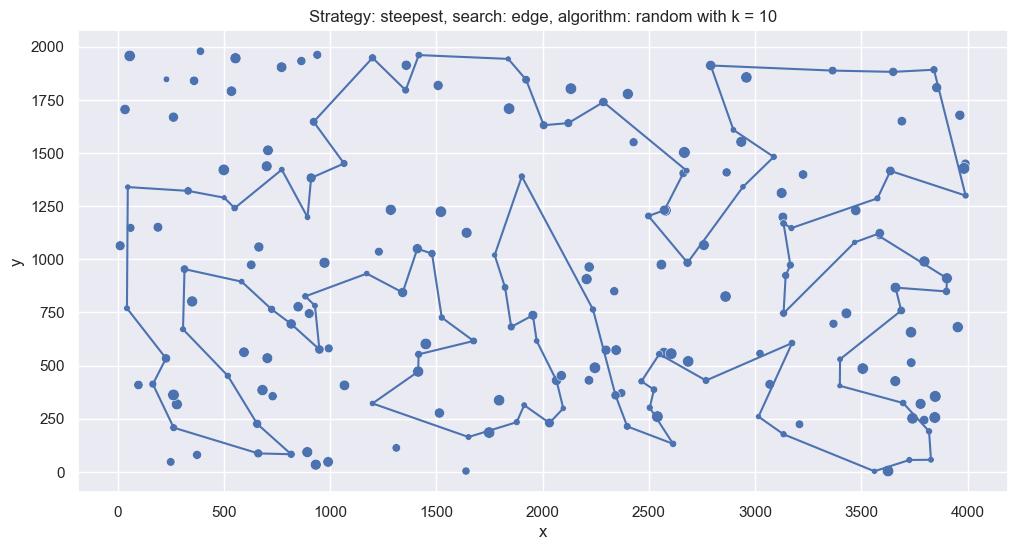

In [20]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_A,
    distance_matrix_A,
    f"Strategy: {strat}, search: {search}, algorithm: {algo} with k = 10",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 10,
    },
    show_indices = False,
)

Best solution: [152, 189, 183, 9, 140, 149, 28, 20, 60, 148, 47, 94, 172, 179, 185, 99, 130, 95, 110, 86, 166, 194, 176, 113, 103, 127, 89, 163, 153, 77, 141, 61, 36, 177, 5, 78, 175, 45, 80, 190, 136, 73, 164, 31, 54, 193, 117, 198, 131, 1, 27, 38, 63, 135, 122, 133, 90, 191, 51, 121, 25, 138, 104, 56, 8, 21, 82, 111, 144, 160, 33, 11, 139, 134, 147, 6, 188, 169, 195, 168, 29, 39, 0, 109, 35, 143, 159, 106, 124, 62, 18, 55, 34, 145, 15, 70, 3, 155, 184, 170]
Time to calculate: 183.7853
Objective function statistics:
minimum = 49045
mean = 53099.35
maximum = 60284


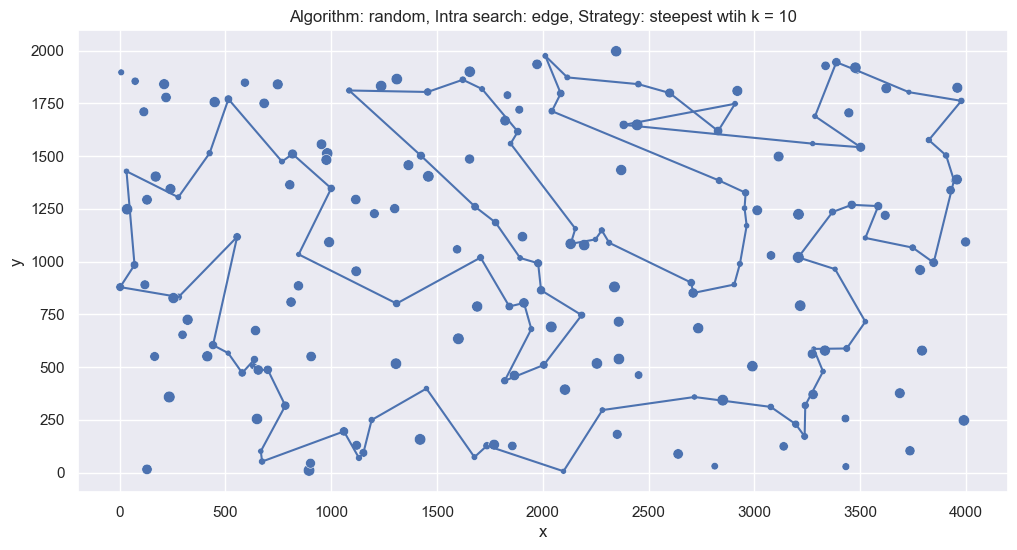

In [21]:
strat = 'steepest'
search = 'edge'
algo = 'random'

experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} wtih k = 10",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 10,
    },
    show_indices = False,
)

### K = 20

Best solution: [55, 52, 106, 178, 49, 37, 148, 9, 62, 102, 144, 14, 138, 39, 27, 90, 165, 119, 40, 185, 57, 129, 92, 145, 78, 31, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 100, 26, 124, 94, 63, 53, 180, 154, 135, 70, 127, 123, 112, 4, 190, 10, 177, 54, 184, 131, 149, 43, 116, 105, 65, 162, 151, 133, 79, 80, 176, 51, 118, 59, 115, 139, 41, 193, 159, 42, 160, 34, 181, 146, 22, 18, 69, 108, 140, 68, 46, 0, 117, 143, 183, 89, 23, 137, 12, 167]
Time to calculate: 242.5341
Objective function statistics:
minimum = 73484
mean = 77894.29
maximum = 84130


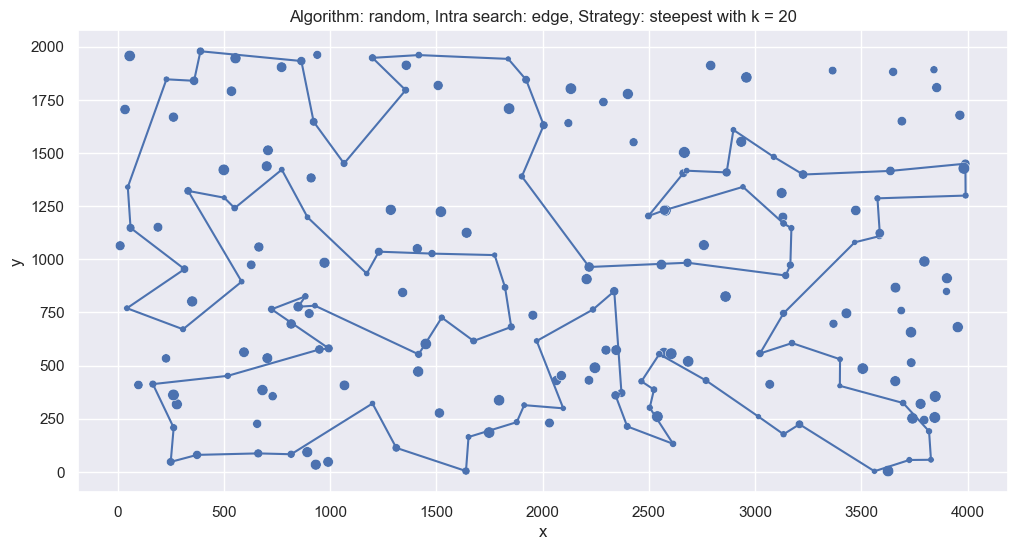

In [22]:
experiment(
    dataset_A,
    distance_matrix_A,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 20",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 20,
    },
    show_indices = False,
)

Best solution: [107, 40, 63, 135, 131, 121, 1, 198, 117, 193, 31, 54, 73, 136, 190, 80, 175, 78, 142, 5, 177, 25, 134, 139, 11, 182, 138, 33, 160, 144, 111, 56, 104, 157, 8, 82, 21, 36, 61, 79, 91, 141, 77, 81, 153, 163, 103, 89, 127, 114, 113, 180, 176, 194, 166, 86, 95, 130, 185, 179, 94, 47, 148, 20, 28, 149, 140, 183, 152, 170, 34, 55, 18, 62, 128, 124, 106, 143, 35, 109, 0, 12, 29, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 90, 122, 133, 10, 72]
Time to calculate: 242.3507
Objective function statistics:
minimum = 46476
mean = 49239.81
maximum = 52665


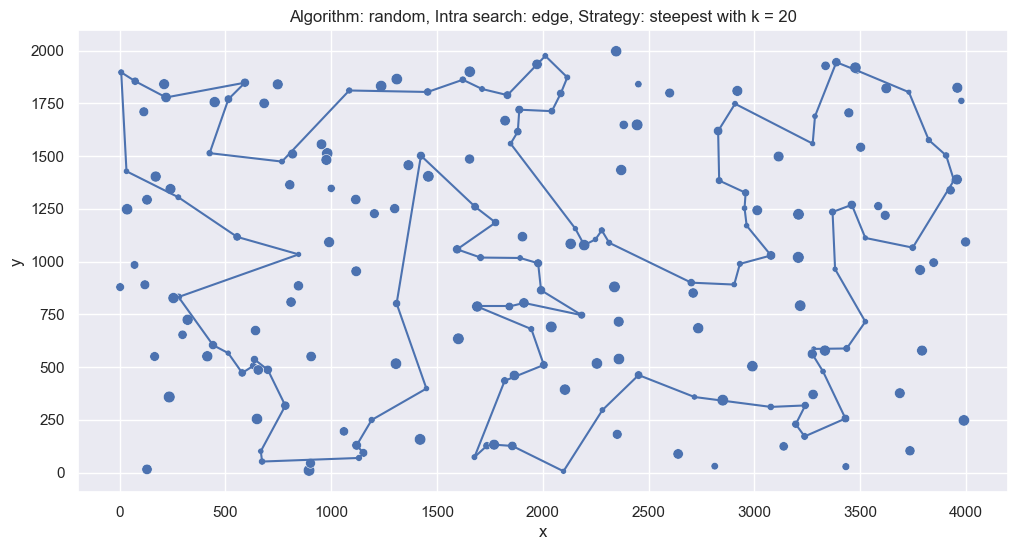

In [23]:
experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 20",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 20,
    },
    show_indices = False,
)

### K = 50

Best solution: [133, 79, 80, 176, 137, 0, 117, 143, 183, 89, 23, 186, 148, 9, 62, 102, 144, 14, 49, 3, 178, 106, 52, 55, 57, 92, 185, 40, 165, 90, 81, 196, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 129, 2, 75, 86, 100, 26, 101, 1, 97, 152, 124, 94, 63, 182, 121, 53, 180, 154, 135, 70, 127, 123, 149, 131, 65, 116, 43, 184, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 146, 22, 18, 108, 159, 193, 41, 181, 42, 5, 115, 139, 68, 46, 118, 59, 51, 151, 162]
Time to calculate: 464.8045
Objective function statistics:
minimum = 71128
mean = 75074.33
maximum = 81175


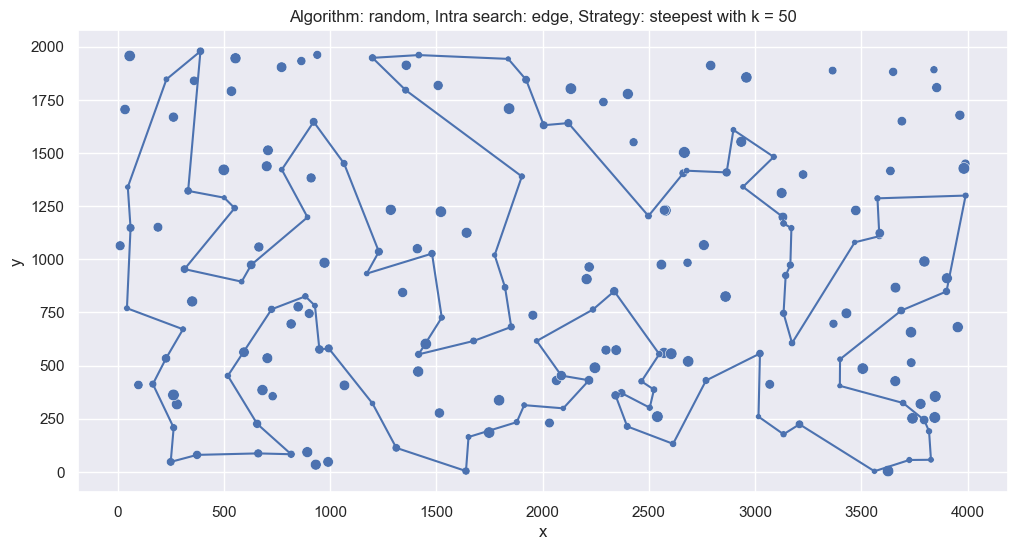

In [24]:
experiment(
    dataset_A,
    distance_matrix_A,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 50",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 50,
    },
    show_indices = False,
)

Best solution: [162, 45, 142, 175, 78, 5, 177, 25, 182, 138, 139, 11, 33, 160, 29, 0, 109, 35, 111, 144, 104, 8, 82, 21, 61, 36, 141, 77, 81, 153, 187, 163, 165, 127, 137, 114, 89, 103, 113, 176, 166, 86, 185, 179, 94, 47, 148, 20, 28, 149, 4, 140, 183, 95, 106, 124, 62, 18, 55, 34, 170, 152, 184, 155, 3, 70, 15, 145, 168, 195, 13, 132, 169, 188, 6, 134, 85, 147, 191, 90, 122, 40, 63, 102, 135, 125, 51, 121, 131, 1, 198, 117, 193, 54, 31, 164, 73, 136, 190, 80]
Time to calculate: 491.0439
Objective function statistics:
minimum = 46440
mean = 49092.33
maximum = 52405


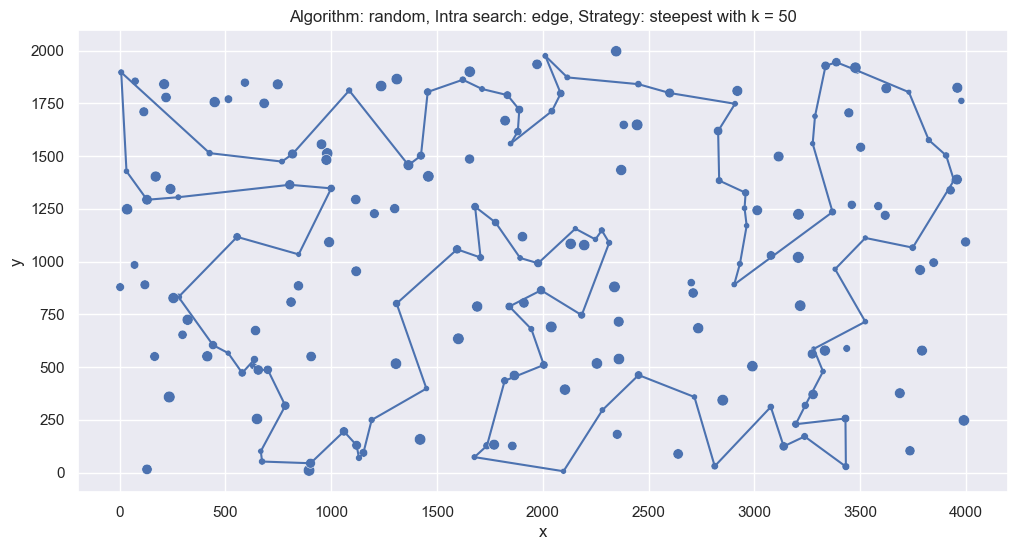

In [25]:
experiment(
    dataset_B,
    distance_matrix_B,
    f"Algorithm: {algo}, Intra search: {search}, Strategy: {strat} with k = 50",
    init_local_search,
    **{
        "strategy": strat,
        "intra_search": search,  
        "debug_mode": True,
        "algo_to_enchance": algo,
        "candidate_numbers": 50,
    },
    show_indices = False,
)